This notebook was sourced from <https://www.streambatch.io/knowledge/ndvi-from-sentinel-2-imagery-using-stac>

In [5]:
import pystac_client
import stackstac
import matplotlib.pyplot as plt

In [6]:
point_lat, point_lon = 45.5, -95.5 # Kolstad Lake Waterfowl Production Area
sentinel_search_url = "https://earth-search.aws.element84.com/v1"
sentinel_stac_client = pystac_client.Client.open(sentinel_search_url)
items = sentinel_stac_client.search(
       intersects=dict(type="Point", coordinates=(point_lon, point_lat)),
       collections=["sentinel-2-l2a"]).item_collection()
len(items)

2998

In [7]:
sentinel_stack = stackstac.stack(items, assets=["red", "nir", "scl"],
                          bounds=[point_lon-0.0005, point_lat-0.0005, point_lon+0.0005, point_lat+0.0005],
                          gdal_env=stackstac.DEFAULT_GDAL_ENV.updated(
                               {'GDAL_HTTP_MAX_RETRY': 3,
                                'GDAL_HTTP_RETRY_DELAY': 5,
                               }),
                          epsg=4326, chunksize=(1, 1, 50, 50)).rename(
       {'x': 'lon', 'y': 'lat'}).to_dataset(dim='band')

In [8]:
sentinel_stack

<xarray.Dataset> Size: 24MB
Dimensions:                                  (time: 2998, lat: 21, lon: 12,
                                              band: 3)
Coordinates: (12/53)
  * time                                     (time) datetime64[ns] 24kB 2017-...
    id                                       (time) <U24 288kB 'S2A_15TUL_201...
  * lon                                      (lon) float64 96B -95.5 ... -95.5
  * lat                                      (lat) float64 168B 45.5 ... 45.5
    s2:nodata_pixel_percentage               (time) object 24kB 26.258034 ... 0
    mgrs:latitude_band                       <U1 4B 'T'
    ...                                       ...
    view:incidence_angle                     (time) object 24kB None ... 5.04...
    s2:tile_id                               (time) object 24kB None ... 'S2C...
    gsd                                      (band) int32 12B 10 10 20
    raster:bands                             (band) object 24B None ... [{'no...
    title                                    (band) object 24B None ... 'Scen...
    epsg                                     int32 4B 4326
Dimensions without coordinates: band
Data variables:
    red                                      (time, lat, lon) float64 6MB dask.array<chunksize=(1, 21, 12), meta=np.ndarray>
    nir                                      (time, lat, lon) float64 6MB dask.array<chunksize=(1, 21, 12), meta=np.ndarray>
    scl                                      (time, lat, lon) float64 6MB dask.array<chunksize=(1, 21, 12), meta=np.ndarray>
Attributes:
    spec:           RasterSpec(epsg=4326, bounds=(-95.50050188326006, 45.4994...
    crs:            epsg:4326
    transform:      | 0.00, 0.00,-95.50|\n| 0.00,-0.00, 45.50|\n| 0.00, 0.00,...
    resolution_xy:  (8.480023822371522e-05, 4.846094052227546e-05)

In [22]:
sentinel_stack['ndvi'] = (sentinel_stack['nir'] - sentinel_stack['red'])/\
                        (sentinel_stack['nir'] + sentinel_stack['red'])
sentinel_stack = sentinel_stack[['ndvi', 'scl']]
sentinel_stack = sentinel_stack.drop([c for c in sentinel_stack.coords if not (c in ['time', 'lat', 'lon'])])
sentinel_stack

C:\Users\rossb\AppData\Local\Temp\ipykernel_40332\1659960584.py:4: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  sentinel_stack = sentinel_stack.drop([c for c in sentinel_stack.coords if not (c in ['time', 'lat', 'lon'])])


<xarray.Dataset> Size: 12MB
Dimensions:  (time: 2998, lat: 21, lon: 12)
Coordinates:
  * time     (time) datetime64[ns] 24kB 2017-01-03T17:30:23.064000 ... 2025-0...
  * lon      (lon) float64 96B -95.5 -95.5 -95.5 -95.5 ... -95.5 -95.5 -95.5
  * lat      (lat) float64 168B 45.5 45.5 45.5 45.5 45.5 ... 45.5 45.5 45.5 45.5
Data variables:
    ndvi     (time, lat, lon) float64 6MB dask.array<chunksize=(1, 21, 12), meta=np.ndarray>
    scl      (time, lat, lon) float64 6MB dask.array<chunksize=(1, 21, 12), meta=np.ndarray>
Attributes:
    spec:           RasterSpec(epsg=4326, bounds=(-95.50050188326006, 45.4994...
    crs:            epsg:4326
    transform:      | 0.00, 0.00,-95.50|\n| 0.00,-0.00, 45.50|\n| 0.00, 0.00,...
    resolution_xy:  (8.480023822371522e-05, 4.846094052227546e-05)

In [23]:
sentinel_point = sentinel_stack.interp(lat=point_lat, lon=point_lon,
                                      method="nearest")
sentinel_stack

<xarray.Dataset> Size: 12MB
Dimensions:  (time: 2998, lat: 21, lon: 12)
Coordinates:
  * time     (time) datetime64[ns] 24kB 2017-01-03T17:30:23.064000 ... 2025-0...
  * lon      (lon) float64 96B -95.5 -95.5 -95.5 -95.5 ... -95.5 -95.5 -95.5
  * lat      (lat) float64 168B 45.5 45.5 45.5 45.5 45.5 ... 45.5 45.5 45.5 45.5
Data variables:
    ndvi     (time, lat, lon) float64 6MB dask.array<chunksize=(1, 21, 12), meta=np.ndarray>
    scl      (time, lat, lon) float64 6MB dask.array<chunksize=(1, 21, 12), meta=np.ndarray>
Attributes:
    spec:           RasterSpec(epsg=4326, bounds=(-95.50050188326006, 45.4994...
    crs:            epsg:4326
    transform:      | 0.00, 0.00,-95.50|\n| 0.00,-0.00, 45.50|\n| 0.00, 0.00,...
    resolution_xy:  (8.480023822371522e-05, 4.846094052227546e-05)

In [24]:
sentinel_point = sentinel_point.sel(time=slice('2022-04-01', '2024-11-01'))

In [25]:
sentinel_point.load()

<xarray.Dataset> Size: 17kB
Dimensions:  (time: 727)
Coordinates:
  * time     (time) datetime64[ns] 6kB 2022-04-02T17:31:03.245000 ... 2024-10...
    lat      float64 8B 45.5
    lon      float64 8B -95.5
Data variables:
    ndvi     (time) float64 6kB 0.4489 0.485 0.3358 ... 0.8537 0.5815 0.5913
    scl      (time) float64 6kB 5.0 5.0 5.0 5.0 8.0 8.0 ... 4.0 4.0 4.0 5.0 5.0
Attributes:
    spec:           RasterSpec(epsg=4326, bounds=(-95.50050188326006, 45.4994...
    crs:            epsg:4326
    transform:      | 0.00, 0.00,-95.50|\n| 0.00,-0.00, 45.50|\n| 0.00, 0.00,...
    resolution_xy:  (8.480023822371522e-05, 4.846094052227546e-05)

In [26]:
sentinel_table = sentinel_point.to_dataframe()

<Axes: xlabel='time'>

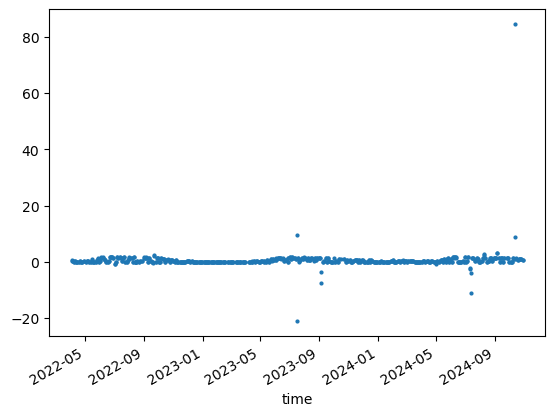

In [27]:
sentinel_table['ndvi'].plot(label='unfiltered', marker='o', linestyle='',markersize=2)

<Axes: xlabel='time'>

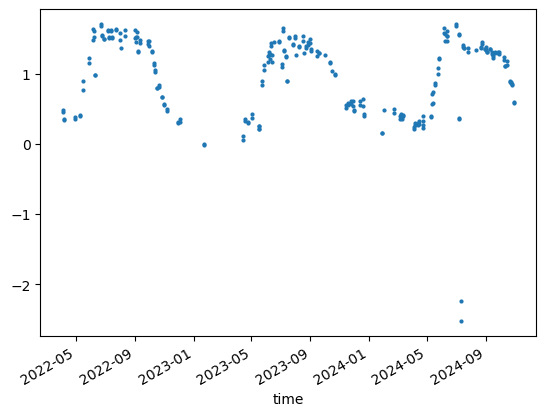

In [28]:
sentinel_table_filtered = sentinel_table[(sentinel_table['scl'] == 4) |
                                        (sentinel_table['scl'] == 5)]
sentinel_table_filtered['ndvi'].plot(label='unfiltered', marker='o', linestyle='',markersize=2)

In [1]:
from rasterstats import zonal_stats

In [ ]:
import geopandas as gpd
import numpy as np
import pandas as pd

# Load the polygon
geojson_path = r"c:\Users\rossb\OneDrive - HQPLANTATIONS PTY LTD\Documents\code\my_code\satellite-data-toolbox\files\661_GAMBUBAL_215_20.geojson"
gdf = gpd.read_file(geojson_path)

# Get the bounds of the polygon for more efficient data loading
bounds = gdf.total_bounds  # [minx, miny, maxx, maxy]

# Create a new search for the polygon area
polygon_geom = gdf.geometry.iloc[0].__geo_interface__
items_polygon = sentinel_stac_client.search(
    intersects=polygon_geom,
    collections=["sentinel-2-l2a"],
    datetime="2022-04-01/2024-11-01"
).item_collection()

print(f"Found {len(items_polygon)} Sentinel-2 scenes for the polygon area")

# Create stack for the polygon area with appropriate buffer
buffer = 0.001  # Small buffer around polygon
sentinel_stack_polygon = stackstac.stack(
    items_polygon, 
    assets=["red", "nir", "scl"],
    bounds=[bounds[0]-buffer, bounds[1]-buffer, bounds[2]+buffer, bounds[3]+buffer],
    gdal_env=stackstac.DEFAULT_GDAL_ENV.updated({
        'GDAL_HTTP_MAX_RETRY': 3,
        'GDAL_HTTP_RETRY_DELAY': 5,
    }),
    epsg=4326, 
    chunksize=(1, 1, 100, 100)
).rename({'x': 'lon', 'y': 'lat'}).to_dataset(dim='band')

# Calculate NDVI
sentinel_stack_polygon['ndvi'] = (sentinel_stack_polygon['nir'] - sentinel_stack_polygon['red']) / \
                                (sentinel_stack_polygon['nir'] + sentinel_stack_polygon['red'])

# Keep only NDVI and SCL bands
sentinel_stack_polygon = sentinel_stack_polygon[['ndvi', 'scl']]
sentinel_stack_polygon = sentinel_stack_polygon.drop([c for c in sentinel_stack_polygon.coords if not (c in ['time', 'lat', 'lon'])])

print("Loading data...")
sentinel_stack_polygon = sentinel_stack_polygon.load()
print("Data loaded successfully")

Found 178 Sentinel-2 scenes for the polygon area
Loading data...


C:\Users\rossb\AppData\Local\Temp\ipykernel_29444\1574252942.py:42: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  sentinel_stack_polygon = sentinel_stack_polygon.drop([c for c in sentinel_stack_polygon.coords if not (c in ['time', 'lat', 'lon'])])
C:\Users\rossb\AppData\Roaming\Python\Python311\site-packages\dask\_task_spec.py:745: RuntimeWarning: divide by zero encountered in divide
  return self.func(*new_argspec)


Data loaded successfully


In [24]:
sentinel_stack_polygon.to_dataframe()

ndvi  scl
time                    lat        lon                      
2022-04-04 00:04:34.314 -28.221418 152.350711  1.683354  4.0
                                   152.350813  1.431611  4.0
                                   152.350916  1.402122  4.0
                                   152.351018  1.426009  4.0
                                   152.351120  1.527500  4.0
...                                                 ...  ...
2024-10-30 00:04:33.967 -28.234170 152.363169 -0.012420  9.0
                                   152.363271 -0.013324  9.0
                                   152.363373 -0.002366  9.0
                                   152.363475  0.002730  9.0
                                   152.363577  0.018814  9.0

[4928108 rows x 2 columns]

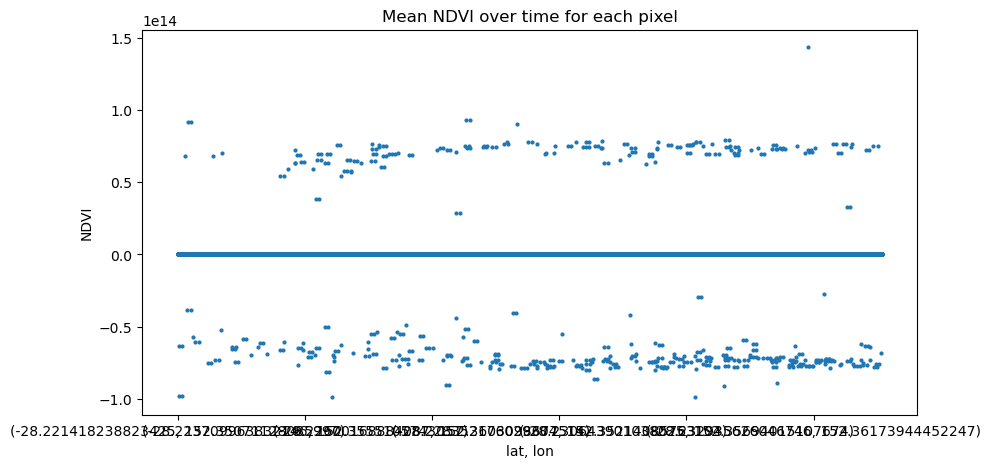

In [31]:
sentinel_stack_polygon.to_dataframe()['ndvi'].unstack('time').mean(axis=1).plot(marker='o', linestyle='', markersize=2, figsize=(10,5))
plt.xlabel('lat, lon')
plt.ylabel('NDVI')
plt.title('Mean NDVI over time for each pixel')
plt.show()